<a href="https://colab.research.google.com/github/BehrozKhawar-23005633/MultiClass-Lung-Disease-Detection/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import shutil
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Verify dataset location**

In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"

 COVID		       Lung_Opacity.metadata.xlsx   README.md.txt
 COVID.metadata.xlsx   Normal			   'Viral Pneumonia'
 Lung_Opacity	       Normal.metadata.xlsx	   'Viral Pneumonia.metadata.xlsx'


# **Count Images in Each Class**
Let's verify the number of images in each category (COVID, Viral Pneumonia, Normal, Lung_Opacity) to check for imbalanced data.

In [ ]:
# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"

# Count images in each category (inside 'images' subfolder)
categories = ["COVID", "Viral Pneumonia", "Normal", "Lung_Opacity"]
for category in categories:
    image_folder = os.path.join(dataset_path, category, "images")  # Access 'images' subfolder
    if os.path.exists(image_folder):  # Ensure the folder exists
        num_images = len(os.listdir(image_folder))
        print(f"Category: {category}, Image Count: {num_images}")
    else:
        print(f"Warning: No 'images' folder found in {category}")

Category: COVID, Image Count: 3616
Category: Viral Pneumonia, Image Count: 3600
Category: Normal, Image Count: 1345
Category: Lung_Opacity, Image Count: 6012


# **Visualizing Dataset Distribution Through Bar Plot**
Let's plot the class distribution to see the imbalance clearly.

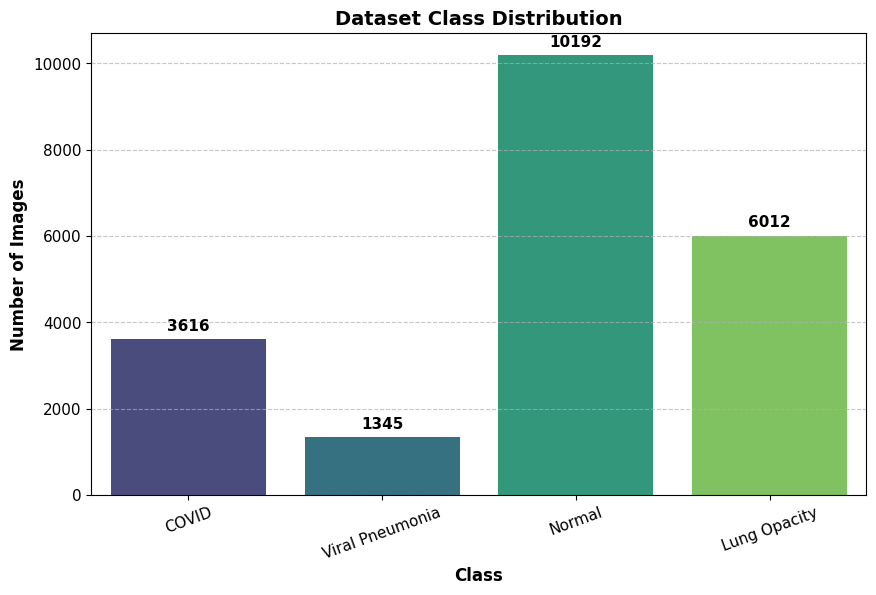

In [ ]:
def plot_class_distribution(categories, image_counts, save_path="class_distribution.png"):
    """
    Plots and saves the dataset class distribution bar chart.
    """
    plt.figure(figsize=(10, 6))

    sns.barplot(x=categories, y=image_counts, hue=categories, palette="viridis", legend=False)

    # Enhancing visualization
    plt.xlabel("Class", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
    plt.title("Dataset Class Distribution", fontsize=14, fontweight='bold')
    plt.xticks(rotation=20, fontsize=11)
    plt.yticks(fontsize=11)

    # Display exact count values on top of bars
    for index, value in enumerate(image_counts):
        plt.text(index, value + 200, str(value), ha='center', fontsize=11, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and show the plot
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

# Data
categories = ["COVID", "Viral Pneumonia", "Normal", "Lung Opacity"]
image_counts = [3616, 1345, 10192, 6012]

# Generate and save plot
plot_class_distribution(categories, image_counts)

# **Data Balance Techniques**

1.   Under Sampling
2.   Over Sampling
3.   Data Augmentation



**1. Under Sampling**

* Reduces the number of images in a Normal images  by randomly selecting a subset to match with Viral Pneumonia images count


In [ ]:
def undersample_class(class_path, target_count):
    images_folder = os.path.join(class_path, "images")
    all_images = os.listdir(images_folder)

    if len(all_images) > target_count:
        # Randomly select images to keep
        selected_images = random.sample(all_images, target_count)

        # Move unselected images to a backup folder
        backup_folder = os.path.join(class_path, "backup_images")
        os.makedirs(backup_folder, exist_ok=True)

        for img in all_images:
            if img not in selected_images:
                shutil.move(os.path.join(images_folder, img), os.path.join(backup_folder, img))

        print(f"Undersampling Complete: Retained {target_count} images in {class_path}")

# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"

# Apply undersampling to Normal class
undersample_class(os.path.join(dataset_path, "Normal"), target_count=1345)


**Undersampling Bar Plot**

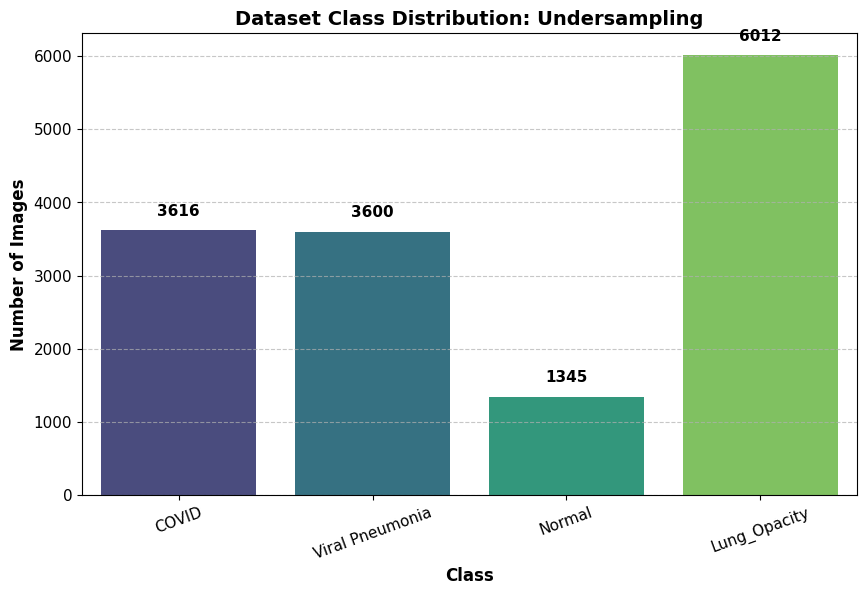

In [ ]:
def count_images(dataset_path, categories):
    """
    Counts the number of images in each class after undersampling.
    """
    image_counts = []
    for category in categories:
        image_folder = os.path.join(dataset_path, category, "images")
        if os.path.exists(image_folder):
            num_images = len(os.listdir(image_folder))
            image_counts.append(num_images)
        else:
            image_counts.append(0)  # In case the folder is missing
            print(f"Warning: No 'images' folder found in {category}")
    return image_counts

def plot_class_distribution(categories, image_counts, save_path="updated_class_distribution.png"):
    """
    Plots and saves the updated dataset class distribution bar chart.
    """
    plt.figure(figsize=(10, 6))

    sns.barplot(x=categories, y=image_counts, hue=categories, palette="viridis", legend=False)

    # Enhancing visualization
    plt.xlabel("Class", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
    plt.title("Dataset Class Distribution: Undersampling", fontsize=14, fontweight='bold')
    plt.xticks(rotation=20, fontsize=11)
    plt.yticks(fontsize=11)

    # Display exact count values on top of bars
    for index, value in enumerate(image_counts):
        plt.text(index, value + 200, str(value), ha='center', fontsize=11, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and show the plot
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"
categories = ["COVID", "Viral Pneumonia", "Normal", "Lung_Opacity"]

# Count updated images
updated_image_counts = count_images(dataset_path, categories)

# Generate and save the updated plot
plot_class_distribution(categories, updated_image_counts)

**2. OverSampling**

* Increases the number of images in Viral Penumenia class by duplicating existing images to match Closet Class i-e Covid Samples Images





In [ ]:
def oversample_class(class_path, target_count):
    images_folder = os.path.join(class_path, "images")
    all_images = os.listdir(images_folder)
    current_count = len(all_images)

    if current_count < target_count:
        num_to_add = target_count - current_count
        print(f"Oversampling: Need to add {num_to_add} images to {class_path}")

        for i in range(num_to_add):
            img_to_copy = random.choice(all_images)  # Randomly pick an image
            new_img_name = f"copy_{i}_{img_to_copy}"  # Rename the duplicate
            shutil.copy(os.path.join(images_folder, img_to_copy),
                        os.path.join(images_folder, new_img_name))

        print(f"Oversampling Complete: {target_count} images now in {class_path}")
    else:
        print(f"Oversampling Not Needed: {class_path} already has sufficient images")

# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"

# Apply oversampling to Viral Pneumonia class (match COVID count of ~3,600)
oversample_class(os.path.join(dataset_path, "Viral Pneumonia"), target_count=3600)


Oversampling Not Needed: /content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia already has sufficient images


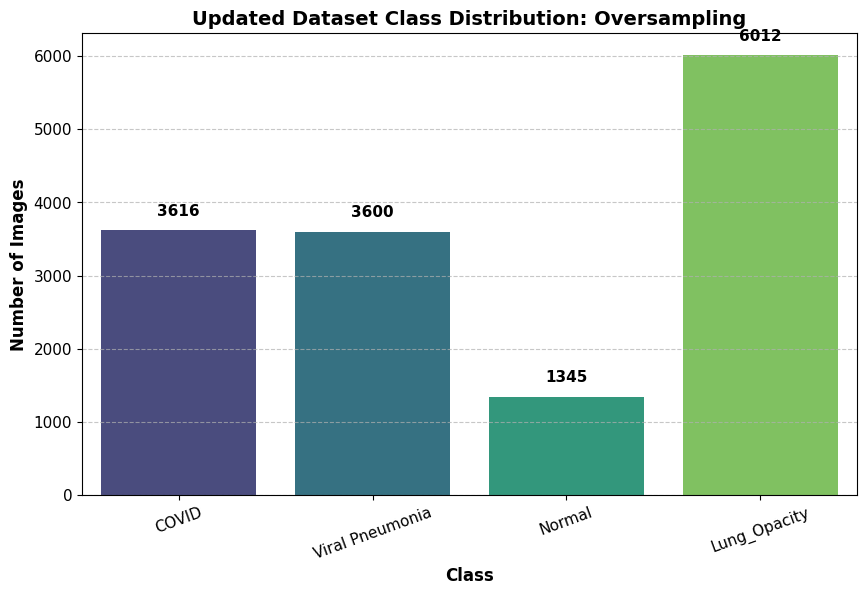

In [ ]:
def count_images(dataset_path, categories):
    """
    Counts the number of images in each class after oversampling.
    """
    image_counts = []
    for category in categories:
        image_folder = os.path.join(dataset_path, category, "images")
        if os.path.exists(image_folder):
            num_images = len(os.listdir(image_folder))
            image_counts.append(num_images)
        else:
            image_counts.append(0)  # In case the folder is missing
            print(f"Warning: No 'images' folder found in {category}")
    return image_counts

def plot_class_distribution(categories, image_counts, save_path="updated_class_distribution.png"):
    """
    Plots and saves the updated dataset class distribution bar chart.
    """
    plt.figure(figsize=(10, 6))

    sns.barplot(x=categories, y=image_counts, hue=categories, palette="viridis", legend=False)

    # Enhancing visualization
    plt.xlabel("Class", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
    plt.title("Updated Dataset Class Distribution: Oversampling", fontsize=14, fontweight='bold')
    plt.xticks(rotation=20, fontsize=11)
    plt.yticks(fontsize=11)

    # Display exact count values on top of bars
    for index, value in enumerate(image_counts):
        plt.text(index, value + 200, str(value), ha='center', fontsize=11, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and show the plot
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"
categories = ["COVID", "Viral Pneumonia", "Normal", "Lung_Opacity"]

# Count updated images
updated_image_counts = count_images(dataset_path, categories)

# Generate and save the updated plot
plot_class_distribution(categories, updated_image_counts)

## **Data Augmentation**

*   We will test augmentation techniques here and decide which are gonna be use in our learning models



**Step 1: Rotation Augmentation**

*    Applies random rotation to an image.



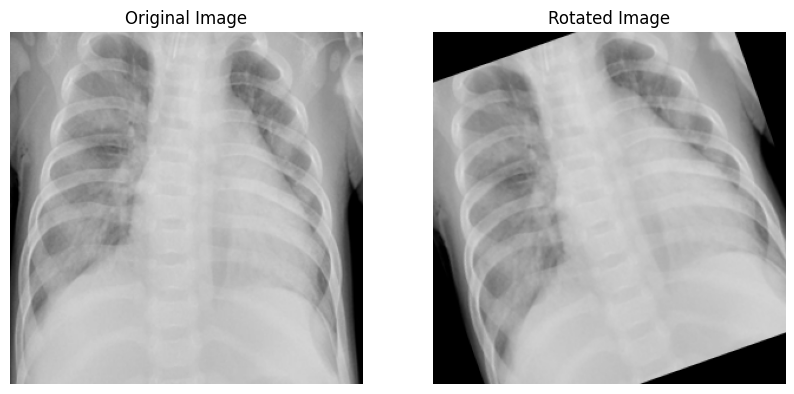

In [ ]:
def apply_rotation(image_path, rotation_range=30):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height, width = image.shape[:2]

    # Choose a random rotation angle
    angle = random.uniform(-rotation_range, rotation_range)

    # Compute rotation matrix
    M = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (width, height))

    return rotated_image

# Select a random image from the dataset
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
sample_image_path = os.path.join(image_folder, sample_image)

# Apply Rotation
rotated_image = apply_rotation(sample_image_path)

# Plot Original vs Rotated Image
original_image = cv2.imread(sample_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rotated_image)
plt.title("Rotated Image")
plt.axis("off")

plt.savefig("rotation_augmentation.png", dpi=300, bbox_inches="tight")
plt.show()


**Step 2: Flipping Augmentation (Horizontal + Vertical)**

*   Applies both horizontal and vertical flip to an image.



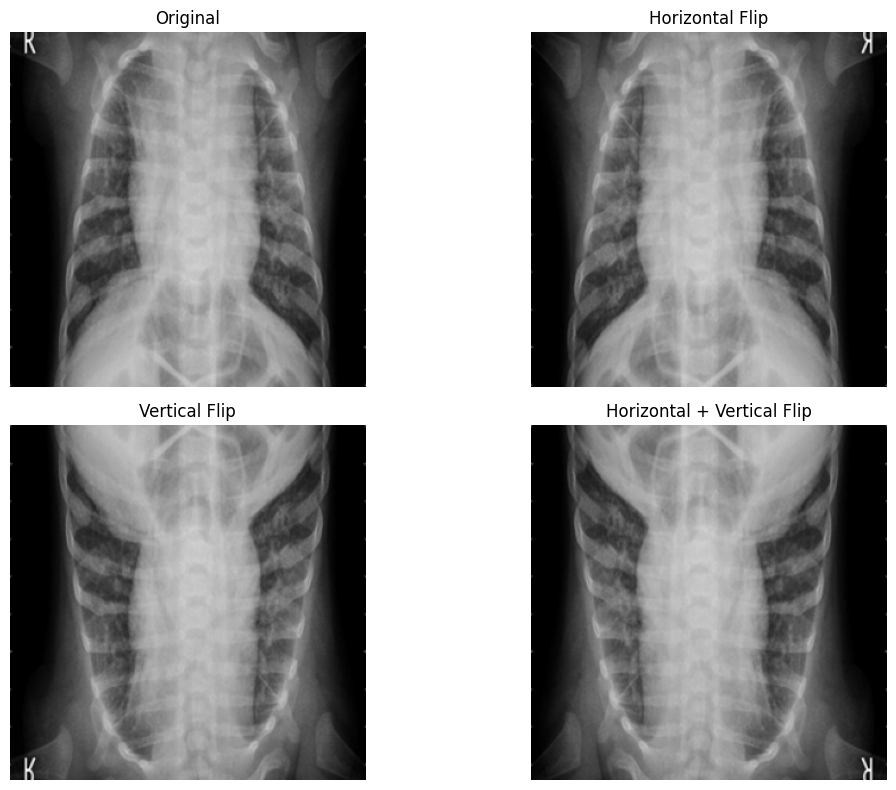

In [ ]:
def apply_flipping(image_path):

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply flipping
    flip_h = cv2.flip(image, 1)   # Horizontal
    flip_v = cv2.flip(image, 0)   # Vertical
    flip_both = cv2.flip(image, -1)  # Both

    return image, flip_h, flip_v, flip_both

# Select a sample image
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, sample_image)

# Apply flipping
original, h_flip, v_flip, both_flip = apply_flipping(image_path)

# Plot the results
titles = ["Original", "Horizontal Flip", "Vertical Flip", "Horizontal + Vertical Flip"]
images = [original, h_flip, v_flip, both_flip]

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.savefig("flipping_augmentation.png", dpi=300, bbox_inches="tight")
plt.show()

**Step-3 Contrast Adjustment**

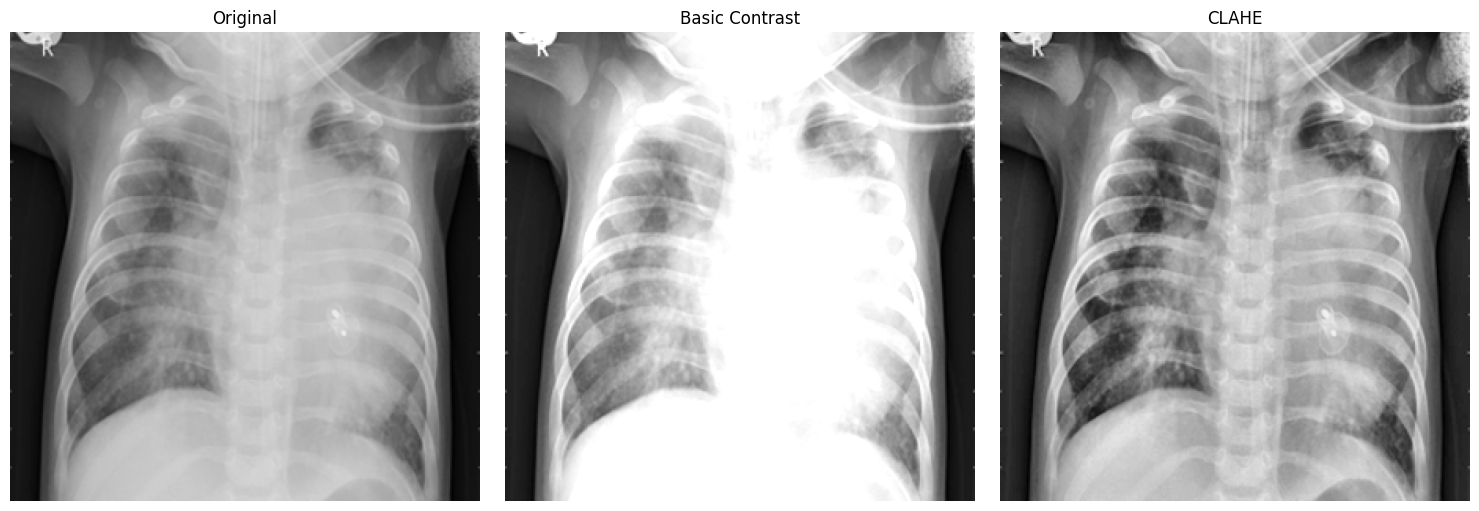

In [ ]:
def contrast_adjustments(image_path):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Basic contrast scaling
    alpha = 1.5  # Contrast control (1.0-3.0)
    beta = 0     # Brightness control (0-100)
    basic_contrast_img = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(image)

    return image, basic_contrast_img, clahe_img

# Pick a random image from dataset
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, sample_image)

# Apply contrast methods
original, contrast_scaled, clahe_result = contrast_adjustments(image_path)

# Plot
titles = ["Original", "Basic Contrast", "CLAHE"]
images = [original, contrast_scaled, clahe_result]

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.savefig("contrast_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

**Step-4 Zooming & Cropping Augmentation**


*  Creates synthetic examples where the chest X-ray is zoomed in slightly and cropped.



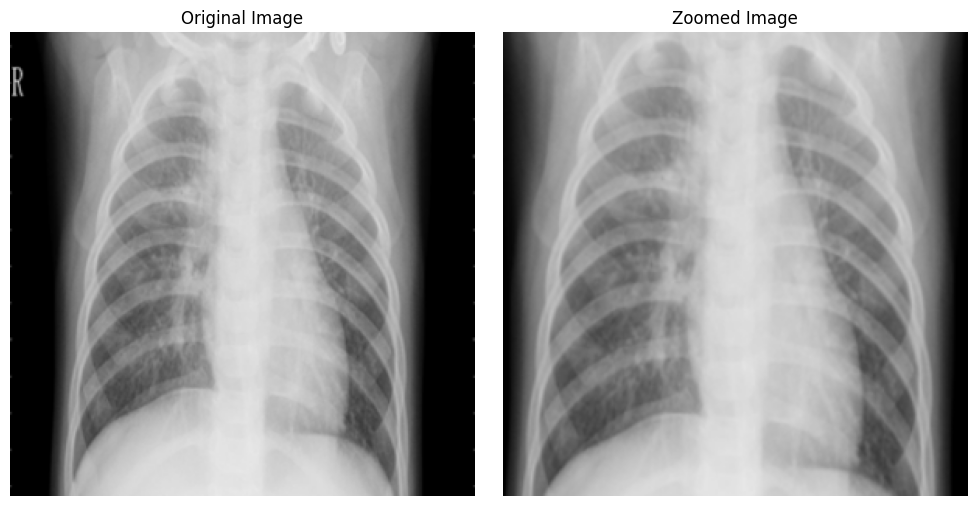

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

def apply_zoom_crop(image_path, zoom_factor=1.2):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # Calculate cropping boundaries
    new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)
    start_h, start_w = (h - new_h) // 2, (w - new_w) // 2
    cropped_img = image[start_h:start_h+new_h, start_w:start_w+new_w]

    # Resize back to original size
    zoomed_img = cv2.resize(cropped_img, (w, h), interpolation=cv2.INTER_LINEAR)

    return image, zoomed_img

# Random image from dataset
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, sample_image)

# Apply zoom
original, zoomed = apply_zoom_crop(image_path)

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(zoomed)
plt.title("Zoomed Image")
plt.axis("off")

plt.tight_layout()
plt.savefig("zoomed_augmentation.png", dpi=300, bbox_inches="tight")
plt.show()


**Step-5 Noise & Blur Augmentation**

*       Applies Gaussian blur and noise to an image.



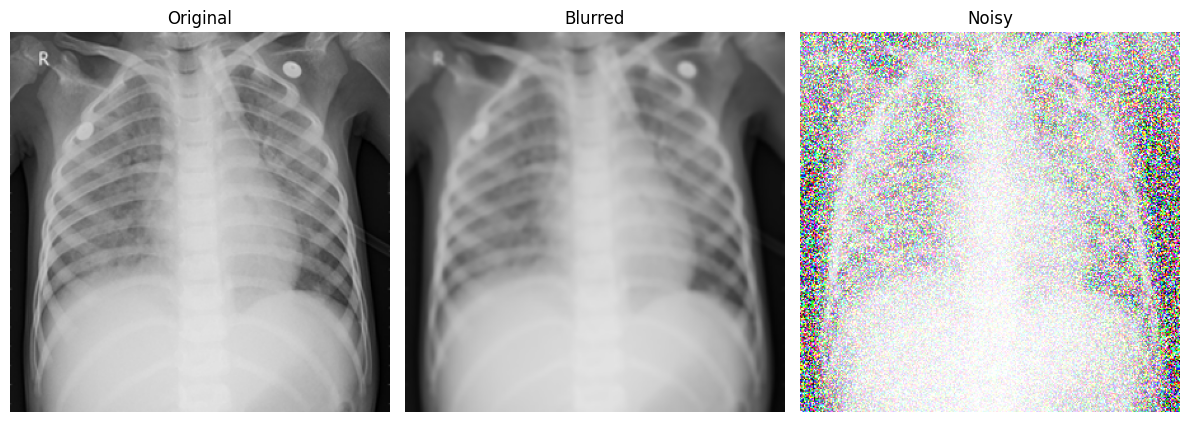

In [ ]:
def apply_noise_blur(image_path):
    """
    Applies Gaussian blur and noise to an image.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(image, (7, 7), 0)

    # Add Gaussian Noise
    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    noisy = cv2.add(image, noise)

    return image, blurred, noisy

# Pick a random image
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, sample_image)

# Apply augmentations
original, blurred_img, noisy_img = apply_noise_blur(image_path)

# Plot results
titles = ["Original", "Blurred", "Noisy"]
images = [original, blurred_img, noisy_img]

plt.figure(figsize=(12, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.savefig("noise_blur_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


**Final Augmentation Function**

*   Below is a clean, reusable data augmentation function that combines all the approved augmentation techniques



In [ ]:
def apply_augmentations_with_label(image):
    applied = []

    # --- Rotation ---
    angle = random.uniform(-15, 15)
    applied.append(f"Rotated({angle:.1f}°)")
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h))

    # --- Horizontal Flip ---
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
        applied.append("Flipped")

    # --- CLAHE Contrast ---
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(gray)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    applied.append("CLAHE")

    # --- Zoom + Crop ---
    zoom_factor = 1.2
    zh, zw = int(h / zoom_factor), int(w / zoom_factor)
    start_h, start_w = (h - zh) // 2, (w - zw) // 2
    image = image[start_h:start_h+zh, start_w:start_w+zw]
    image = cv2.resize(image, (w, h))
    applied.append("Zoom")

    # --- Gaussian Blur (Optional) ---
    if random.random() > 0.7:
        image = cv2.GaussianBlur(image, (5, 5), 0)
        applied.append("Blur")

    return image, " + ".join(applied)


**Apply Augmentation Function to a Batch & Visualize Samples**

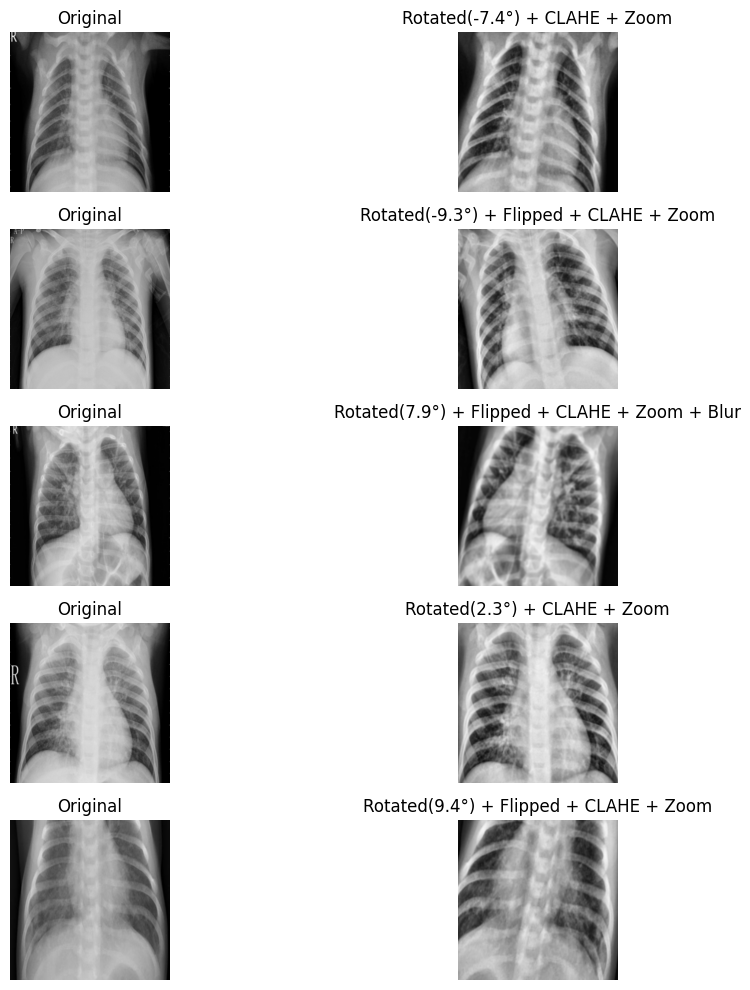

In [ ]:
def load_images_from_folder(folder_path, count=5):
    """
    Loads a small batch of RGB images from a folder.
    """
    image_files = random.sample(os.listdir(folder_path), count)
    images = []
    for file in image_files:
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append((file, img))
    return images

def visualize_augmented_batch_with_labels(folder_path, sample_size=5):
    batch = load_images_from_folder(folder_path, count=sample_size)

    plt.figure(figsize=(12, 2 * sample_size))
    for i, (filename, img) in enumerate(batch):
        aug_img, label = apply_augmentations_with_label(img)

        # Original
        plt.subplot(sample_size, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title("Original")
        plt.axis("off")

        # Augmented with applied label
        plt.subplot(sample_size, 2, 2 * i + 2)
        plt.imshow(aug_img)
        plt.title(label)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("labeled_augmented_batch.png", dpi=300, bbox_inches="tight")
    plt.show()


category_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"

# Run the visualizer
visualize_augmented_batch_with_labels(category_path, sample_size=5)


## **Augmented images Pipeline**

*   Generate and save augmented images for the underrepresented classes so we can match them to ~10,000 samples each.



In [ ]:
def augment_and_save_images(input_dir, output_dir, target_count, augment_fn):
    """
    Generates and saves augmented images until target_count is reached.

    Parameters:
    - input_dir: folder with original images
    - output_dir: where augmented images will be saved
    - target_count: desired total number of images (original + augmented)
    - augment_fn: function to apply augmentations
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_files = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg'))]
    current_count = len(os.listdir(output_dir))
    print(f"Original image count: {current_count}")

    if current_count >= target_count:
        print("No augmentation needed. Already at or above target.")
        return

    num_to_generate = target_count - current_count
    print(f"Generating {num_to_generate} augmented images...")

    i = 0
    while i < num_to_generate:
        img_name = random.choice(image_files)
        img_path = os.path.join(input_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Apply your custom augmentation pipeline
        aug_img = augment_fn(img)

        save_path = os.path.join(output_dir, f"aug_{i}_{img_name}")
        cv2.imwrite(save_path, aug_img)
        i += 1

    print(f"✅ Augmentation complete. Total saved: {num_to_generate} images.")

**Augmented Viral Penumonia Images**

In [ ]:
import os

def custom_augment_pipeline(img):
    # Rotate + CLAHE + Zoom (as tested)
    angle = random.uniform(-12, 12)
    h, w = img.shape[:2]

    # Rotation
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Zoom
    zoom_factor = 1.1
    zh, zw = int(h / zoom_factor), int(w / zoom_factor)
    top = (h - zh) // 2
    left = (w - zw) // 2
    img = img[top:top+zh, left:left+zw]
    img = cv2.resize(img, (w, h))

    return img

# === Configuration ===
input_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
output_folder = "/content/drive/MyDrive/Colab Notebooks/Augmented/Viral Pneumonia"
target_total = 2500

# === Check if augmentation is needed ===
current_count = len(os.listdir(output_folder)) if os.path.exists(output_folder) else 0

if current_count >= target_total:
    print(f"✅ Skipping augmentation. {current_count} images already exist in '{output_folder}'.")
else:
    print(f"🛠️  Current count: {current_count}. Starting augmentation to reach {target_total} images...")
    augment_and_save_images(input_folder, output_folder, target_total, custom_augment_pipeline)


✅ Skipping augmentation. 2500 images already exist in '/content/drive/MyDrive/Colab Notebooks/Augmented/Viral Pneumonia'.


**Augmented Covid Images**

In [ ]:
# === Configuration for COVID ===
input_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/COVID/images"
output_folder = "/content/drive/MyDrive/Colab Notebooks/Augmented/COVID"
target_total = 2500

# === Check if augmentation is needed ===
current_count = len(os.listdir(output_folder)) if os.path.exists(output_folder) else 0

if current_count >= target_total:
    print(f"✅ Skipping augmentation. {current_count} images already exist in '{output_folder}'.")
else:
    print(f"🛠️  Current count: {current_count}. Starting augmentation to reach {target_total} images...")
    augment_and_save_images(input_folder, output_folder, target_total, custom_augment_pipeline)


✅ Skipping augmentation. 2500 images already exist in '/content/drive/MyDrive/Colab Notebooks/Augmented/COVID'.


**Augmented Lung Opacity Images**

In [ ]:
# === Configuration for Lung Opacity ===
input_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Lung_Opacity/images"
output_folder = "/content/drive/MyDrive/Colab Notebooks/Augmented/Lung_Opacity"
target_total = 2500

# === Check if augmentation is needed ===
current_count = len(os.listdir(output_folder)) if os.path.exists(output_folder) else 0

if current_count >= target_total:
    print(f"✅ Skipping augmentation. {current_count} images already exist in '{output_folder}'.")
else:
    print(f"🛠️  Current count: {current_count}. Starting augmentation to reach {target_total} images...")
    augment_and_save_images(input_folder, output_folder, target_total, custom_augment_pipeline)


✅ Skipping augmentation. 2500 images already exist in '/content/drive/MyDrive/Colab Notebooks/Augmented/Lung_Opacity'.


# **Count & Plot Final Class Distribution**

COVID: 2500 images
Viral Pneumonia: 2500 images
Lung_Opacity: 2500 images


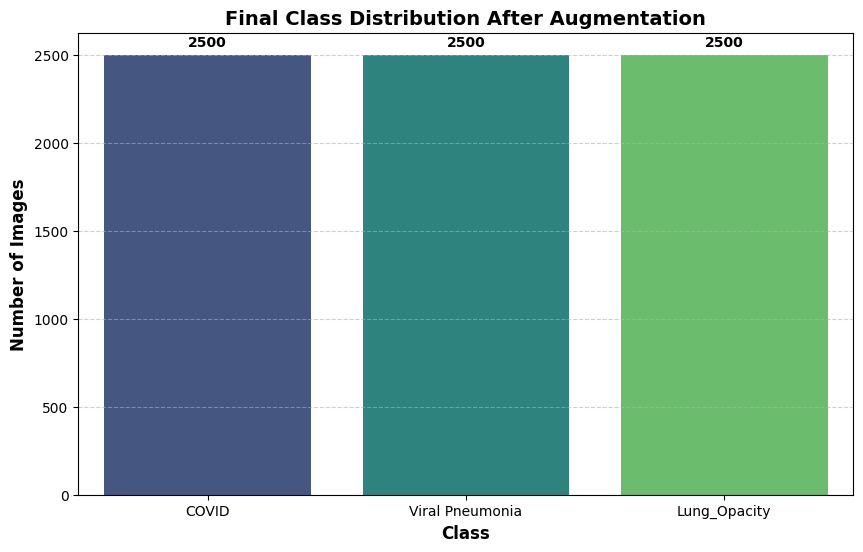

In [ ]:
# Path to augmented dataset
augmented_path = "/content/drive/MyDrive/Colab Notebooks/Augmented"
categories = ["COVID", "Viral Pneumonia", "Lung_Opacity"]

# Count images in each folder
image_counts = {}
for category in categories:
    class_path = os.path.join(augmented_path, category)
    count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg'))])
    image_counts[category] = count
    print(f"{category}: {count} images")

# Plotting
def plot_augmented_distribution(counts_dict, save_path="augmented_distribution_plot.png"):
    categories = list(counts_dict.keys())
    counts = list(counts_dict.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=categories, y=counts, hue=categories, palette="viridis", legend=False)

    for i, count in enumerate(counts):
        plt.text(i, count + 50, str(count), ha='center', fontweight='bold')

    plt.title("Final Class Distribution After Augmentation", fontsize=14, fontweight='bold')
    plt.xlabel("Class", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Call the function to plot
plot_augmented_distribution(image_counts)


**Move Normal Images to Augmented Folder**

In [ ]:
import os
import random
import shutil

def copy_normal_images(source_dir, dest_dir, num_images=2500):
    """
    Copies a random subset of Normal images to the Augmented folder without augmentation.
    Skips copying if images already exist.
    """
    # Check if already exists
    if os.path.exists(dest_dir) and len(os.listdir(dest_dir)) >= num_images:
        print(f"✅ Skipping copy. {len(os.listdir(dest_dir))} images already exist in '{dest_dir}'.")
        return

    os.makedirs(dest_dir, exist_ok=True)

    # Get all image files
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Total images in Normal folder: {len(image_files)}")

    # Randomly select images
    selected = random.sample(image_files, min(num_images, len(image_files)))

    # Copy images
    for i, img_name in enumerate(selected):
        src_path = os.path.join(source_dir, img_name)
        dest_path = os.path.join(dest_dir, f"normal_{i}_{img_name}")
        shutil.copyfile(src_path, dest_path)

    print(f"✅ Copied {len(selected)} images to '{dest_dir}'.")

# === Paths ===
normal_input = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Normal/images"
normal_output = "/content/drive/MyDrive/Colab Notebooks/Augmented/Normal"

# === Run the copy ===
copy_normal_images(normal_input, normal_output, num_images=2500)


✅ Skipping copy. 2689 images already exist in '/content/drive/MyDrive/Colab Notebooks/Augmented/Normal'.


# **Final Train/Val/Test Split Script (Dynamic)**

*   Splits each class folder in source_dir into train/val/test folders under dest_base_dir.
    Automatically skips if already done.



In [ ]:
def split_dataset(source_dir, dest_base_dir, split_ratios=(0.8, 0.1, 0.1), seed=42):
    random.seed(seed)
    class_names = os.listdir(source_dir)

    # Check if already split
    train_path = os.path.join(dest_base_dir, "train")
    if os.path.exists(train_path) and all(
        os.path.exists(os.path.join(train_path, cls)) and len(os.listdir(os.path.join(train_path, cls))) > 0
        for cls in class_names
    ):
        print("✅ Split already exists. Skipping.")
        return

    # Proceed with splitting
    for class_name in class_names:
        class_path = os.path.join(source_dir, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg'))]
        random.shuffle(images)

        total = len(images)
        train_count = int(total * split_ratios[0])
        val_count = int(total * split_ratios[1])
        test_count = total - train_count - val_count

        splits = {
            "train": images[:train_count],
            "val": images[train_count:train_count + val_count],
            "test": images[train_count + val_count:]
        }

        for split_type, split_images in splits.items():
            split_dir = os.path.join(dest_base_dir, split_type, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                src_path = os.path.join(class_path, img)
                dst_path = os.path.join(split_dir, img)
                shutil.copyfile(src_path, dst_path)

        print(f"✅ {class_name}: {train_count} train, {val_count} val, {test_count} test")

# === Paths ===
source_path = "/content/drive/MyDrive/Colab Notebooks/Augmented"
destination_path = "/content/drive/MyDrive/Colab Notebooks/Final_Dataset"

# === Run the split (only if not done already) ===
split_dataset(source_path, destination_path)


✅ Split already exists. Skipping.


# **Build Image Pipelines**

**Step 1 - Use Tenserflow Built-In Pipepline Loader**

*  This is TensorFlow’s built-in pipeline loader — fast, clean, and supports batching and shuffling automatically.





In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# === Dataset paths ===
base_dir = "/content/drive/MyDrive/Colab Notebooks/Final_Dataset"
batch_size = 32
img_size = (224, 224)  # You can adjust if needed

# === Load datasets ===
train_ds = image_dataset_from_directory(
    directory=os.path.join(base_dir, "train"),
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    directory=os.path.join(base_dir, "val"),
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False
)

test_ds = image_dataset_from_directory(
    directory=os.path.join(base_dir, "test"),
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False
)


Found 8150 files belonging to 4 classes.
Found 1018 files belonging to 4 classes.
Found 1020 files belonging to 4 classes.


**Step-2 Add Light Augmentation to Training Pipeline Only**

In [ ]:
from tensorflow.keras import layers

# Light augmentations for training only
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


**Step-3 Normalize & Apply Augmentation**

In [ ]:
# Apply augmentation and normalization to train set only
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .map(lambda x, y: (data_augmentation(x, training=True), y))
    .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

# Just normalize val/test (no augmentation!)
val_ds = (
    val_ds
    .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

test_ds = (
    test_ds
    .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

raw_train_ds = image_dataset_from_directory(
    directory=os.path.join(base_dir, "train"),
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

# ✅ Extract class names before mapping/augmentation
class_names = raw_train_ds.class_names


Found 8150 files belonging to 4 classes.


**Preview One Batch of Training Images**

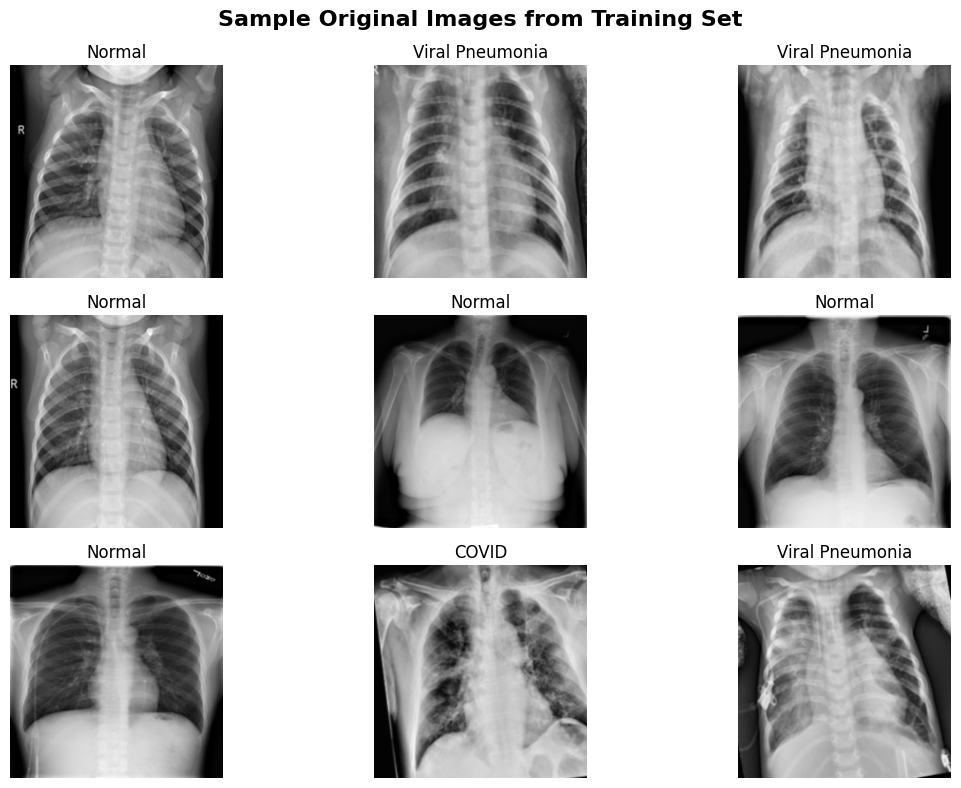

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Grab one batch from the training set

for images, labels in raw_train_ds.take(1):
    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.suptitle("Sample Original Images from Training Set", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# **Custom Deeper CNN Model Implementation**

**Model Summary**

In [ ]:
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),  # ✅ Explicit Input layer

        # Block 1
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        # Block 2
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        # Block 3
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        # Block 4
        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        # Classifier head
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build and view summary
model = build_custom_cnn()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,811,588 (25.98 MB)

 Trainable params: 6,811,588 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

**Compile and Train the Model**

Loss: categorical_crossentropy (you’re using one-hot labels).

Optimizer: Adam (good default choice).

Metrics: accuracy for performance tracking.



In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),  # Low LR for stable training
    metrics=['accuracy']
)


**Add Training Callbacks**


*   ✅ EarlyStopping:
Stops training when validation loss stops improving (prevents overfitting).

*   ✅ ModelCheckpoint:
Saves the best weights (based on validation accuracy).



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_custom_cnn_model.keras", save_best_only=True)
]


In [ ]:
import os
import math

# === Count total images in train and val directories ===
train_dir = "/content/drive/MyDrive/Colab Notebooks/Final_Dataset/train"
val_dir = "/content/drive/MyDrive/Colab Notebooks/Final_Dataset/val"

def count_images_in_directory(directory):
    total = 0
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            total += len(os.listdir(class_path))
    return total

train_count = count_images_in_directory(train_dir)
val_count = count_images_in_directory(val_dir)

# === Set steps based on batch size ===
batch_size = 32
steps_per_epoch = math.ceil(train_count / batch_size)
validation_steps = math.ceil(val_count / batch_size)

print(f"✅ Total train images: {train_count}, steps/epoch: {steps_per_epoch}")
print(f"✅ Total val images: {val_count}, val steps: {validation_steps}")


✅ Total train images: 8150, steps/epoch: 255
✅ Total val images: 1018, val steps: 32


In [ ]:
# Define steps
train_steps = 255  # Based on your total train images / batch size
val_steps = 32     # Based on val images / batch size

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks
)


Epoch 1/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 261s 168ms/step - accuracy: 0.4616 - loss: 1.1580 - val_accuracy: 0.7574 - val_loss: 0.5669
Epoch 2/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7494 - loss: 0.6005 - val_accuracy: 0.7927 - val_loss: 0.4686
Epoch 3/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7821 - loss: 0.5086 - val_accuracy: 0.8075 - val_loss: 0.4478
Epoch 4/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8090 - loss: 0.4536 - val_accuracy: 0.8409 - val_loss: 0.3791
Epoch 5/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8264 - loss: 0.4104 - val_accuracy: 0.8310 - val_loss: 0.3860
Epoch 6/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8352 - loss: 0.3727 - val_accuracy: 0.8880 - val_loss: 0.3231
Epoch 7/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8544 - loss: 0.3258 - val_accuracy: 0.8733 - val_loss: 0.3177
Epoch 8/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8746 - loss: 0.3023 

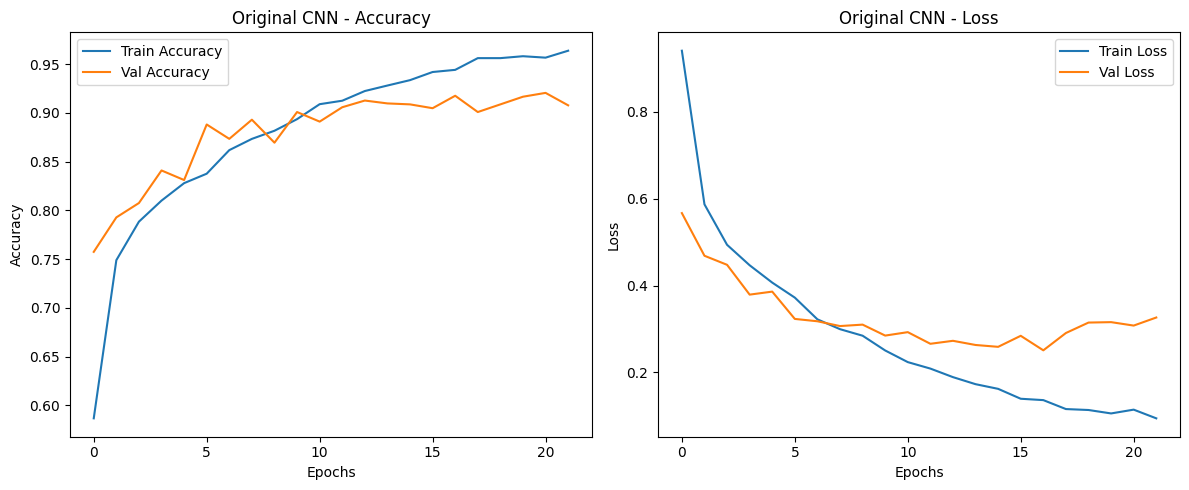

In [ ]:
def plot_training_history(history, model_name="Custom CNN"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history, model_name="Original CNN")

# **CCN Model Improvments**



*   Add Batch Normalization to Improve Learning Stability
*   Use EarlyStopping & ModelCheckpoint in Keras
*   Use EarlyStopping & ModelCheckpoint in Keras format








In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential

def build_improved_cnn(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])
    return model

# Complie the model
model = build_improved_cnn()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add Training Callbacks

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_improved_cnn_model.keras", save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# Train the Model
epochs = 30
steps_per_epoch = len(train_ds)
validation_steps = len(val_ds)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)



Epoch 1/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.6456 - loss: 1.1712 - val_accuracy: 0.3959 - val_loss: 4.9872 - learning_rate: 1.0000e-04
Epoch 2/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8406 - loss: 0.3929 - val_accuracy: 0.7544 - val_loss: 0.7470 - learning_rate: 1.0000e-04
Epoch 3/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8714 - loss: 0.3159 - val_accuracy: 0.8163 - val_loss: 0.4174 - learning_rate: 1.0000e-04
Epoch 4/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9189 - loss: 0.2094 - val_accuracy: 0.8517 - val_loss: 0.3622 - learning_rate: 1.0000e-04
Epoch 5/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9362 - loss: 0.1637 - val_accuracy: 0.9096 - val_loss: 0.3009 - learning_rate: 1.0000e-04
Epoch 6/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9478 - loss: 0.1354 - val_accuracy: 0.8900 - val_loss: 0.3352 - learning_rate: 1.0000e-04
Epoch 7/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/ste

**Plot The Training Results**

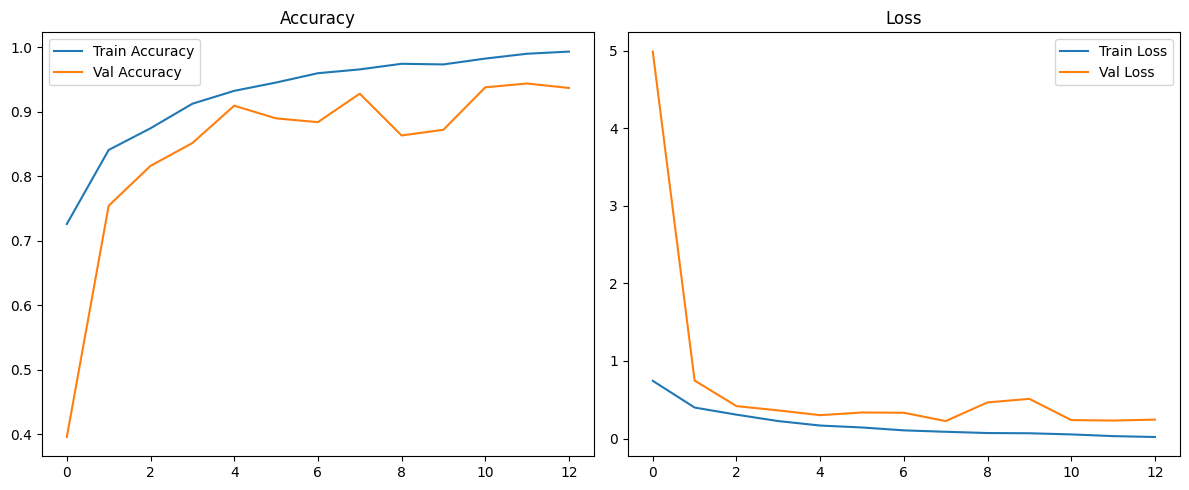

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(history)


# **Visualising CNN Model Test Predictions**

**1-Load the best saved model**

In [ ]:
from tensorflow.keras.models import load_model

# Load best improved model
model = load_model("best_improved_cnn_model.keras")


**2. Make Predictions on Test Set**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


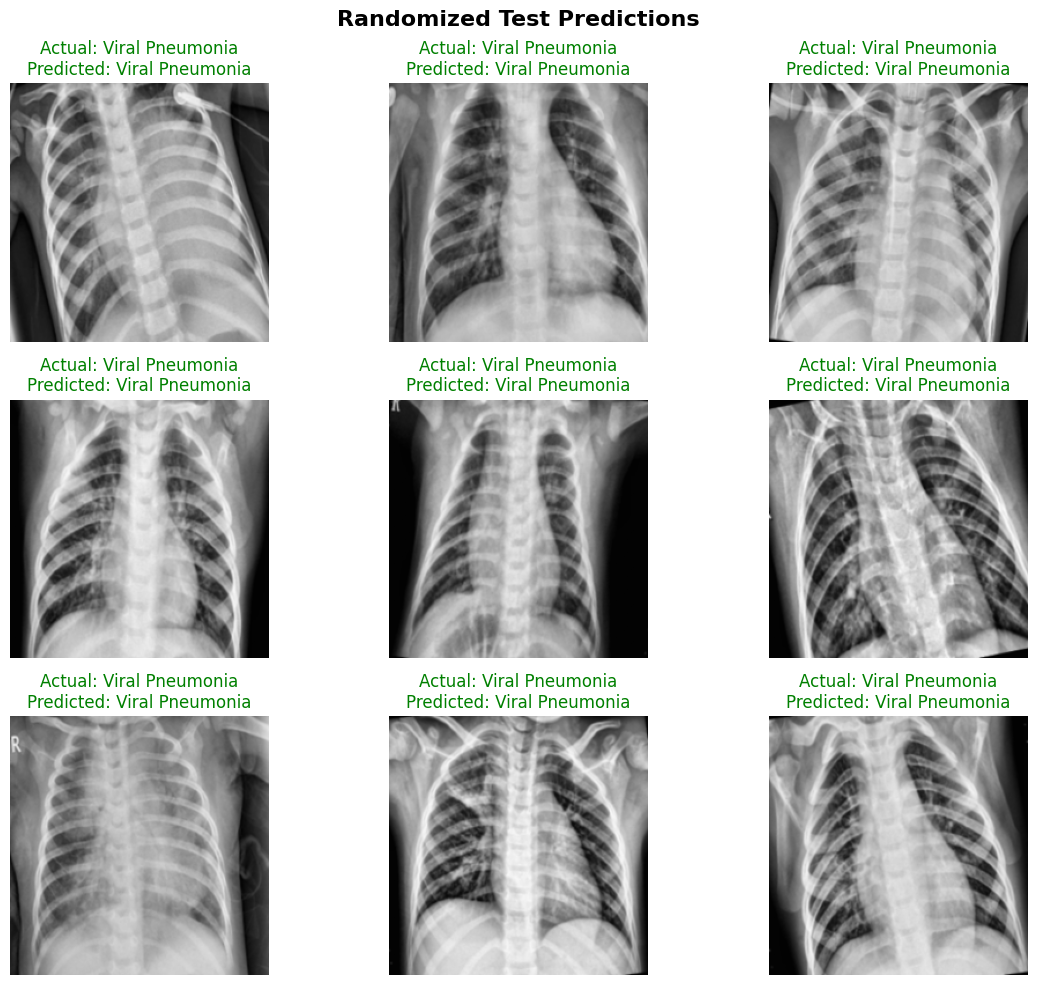

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Shuffle test set and take one batch randomly
shuffled_test = test_ds.shuffle(1000, seed=np.random.randint(1, 10000))

# Set number of samples
num_samples = 9
plt.figure(figsize=(12, 10))

for images, labels in shuffled_test.take(1):
    preds = model.predict(images)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(labels.numpy(), axis=1)

    for i in range(num_samples):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze()
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
        plt.axis("off")

        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"Actual: {true_label}\nPredicted: {pred_label}", color=color)

plt.suptitle("Randomized Test Predictions", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


**3- Classification Report**

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Flatten predictions and labels
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Get class names (from raw_train_ds earlier)
class_labels = class_names  # e.g., ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']

# Generate the report as a dictionary
report_dict = classification_report(
    y_true, y_pred, target_names=class_labels, output_dict=True, zero_division=0
)

# Convert to pandas DataFrame for nice display
report_df = pd.DataFrame(report_dict).transpose()

# Display the key metrics only
print(report_df[["precision", "recall", "f1-score", "support"]].round(3))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

**4-Confusion Matrix**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

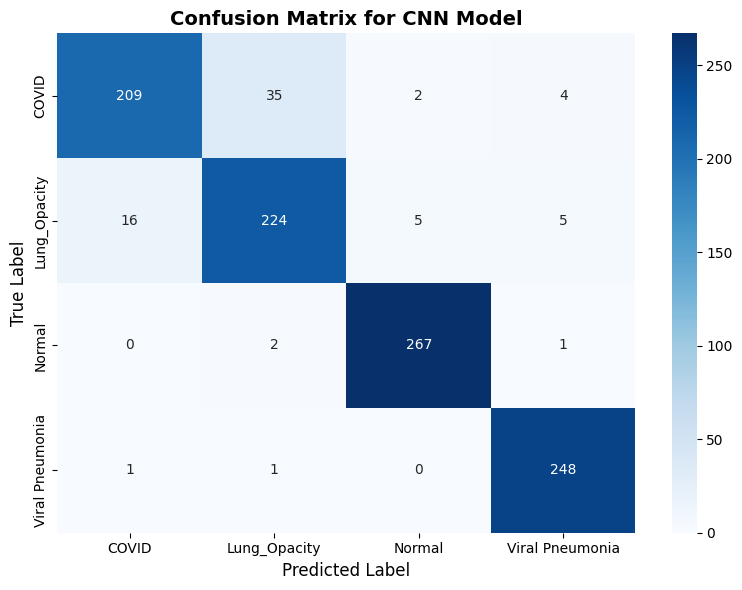

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Reuse y_true and y_pred from your earlier classification report block
# If not available, regenerate them:
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Get class labels
class_labels = class_names  # e.g., ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix for CNN Model", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


# **RES-NET 50 Model**

**Initial Model Improvement**

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# === Define and name the input ===
input_tensor = Input(shape=(224, 224, 3), name="input_image")

# === Load ResNet-50 base ===
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# === Freeze base layers ===
for layer in base_model.layers:
    layer.trainable = False

# === Custom classification head ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(4, activation='softmax')(x)

# === Final model ===
resnet_model = Model(inputs=base_model.input, outputs=output)

# === Compile model ===
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# === Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint("bestresnet50model.keras", save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# === Training Parameters ===
epochs = 30

# === Calculate steps ===
train_image_count = 8151  # Update this if your dataset size changes
val_image_count = 1018    # Update this if needed
batch_size = 32

steps_per_epoch = train_image_count // batch_size
validation_steps = val_image_count // batch_size

# === Train the Model ===
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2541 - loss: 1.6185
Epoch 1: val_loss improved from inf to 1.30289, saving model to bestresnet50model.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.2542 - loss: 1.6179 - val_accuracy: 0.4677 - val_loss: 1.3029 - learning_rate: 1.0000e-04
Epoch 2/30
  1/254 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.3750 - loss: 1.3495

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 1.30289 to 1.30270, saving model to bestresnet50model.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3750 - loss: 1.3495 - val_accuracy: 0.4677 - val_loss: 1.3027 - learning_rate: 1.0000e-04
Epoch 3/30
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3594 - loss: 1.3232
Epoch 3: val_loss improved from 1.30270 to 1.23101, saving model to bestresnet50model.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.3597 - loss: 1.3231 - val_accuracy: 0.4637 - val_loss: 1.2310 - learning_rate: 1.0000e-04
Epoch 4/30
  1/254 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.4375 - loss: 1.2719
Epoch 4: val_loss improved from 1.23101 to 1.23029, saving model to bestresnet50model.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4375 - loss: 1.2719 - val_accuracy: 0.4587 - val_loss: 1.2303 - learning_rate: 1.0000e-04
Epoch 5/30
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4349 - loss: 1.2564
Epoch 5: val_loss improve

# **REST-NET50 Model Improvement**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(4, activation='softmax')(x)

# Build model
resnet_model = Model(inputs=base_model.input, outputs=output)

# Compile
resnet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary
resnet_model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Compile the Model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

resnet_callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("best_resnet50_model.keras", save_best_only=True, monitor='val_loss')
]


**3-Train The Model**

In [ ]:
epochs = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=resnet_callbacks
)


Epoch 1/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.9774 - loss: 0.0622 - val_accuracy: 0.8929 - val_loss: 0.3767
Epoch 2/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9765 - loss: 0.0566 - val_accuracy: 0.8870 - val_loss: 0.3924
Epoch 3/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9793 - loss: 0.0605 - val_accuracy: 0.9332 - val_loss: 0.2302
Epoch 4/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9774 - loss: 0.0644 - val_accuracy: 0.9244 - val_loss: 0.3050
Epoch 5/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9875 - loss: 0.0381 - val_accuracy: 0.9312 - val_loss: 0.2423
Epoch 6/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9824 - loss: 0.0507 - val_accuracy: 0.9273 - val_loss: 0.2833


**4- Plotting ResNet-50 Training History**

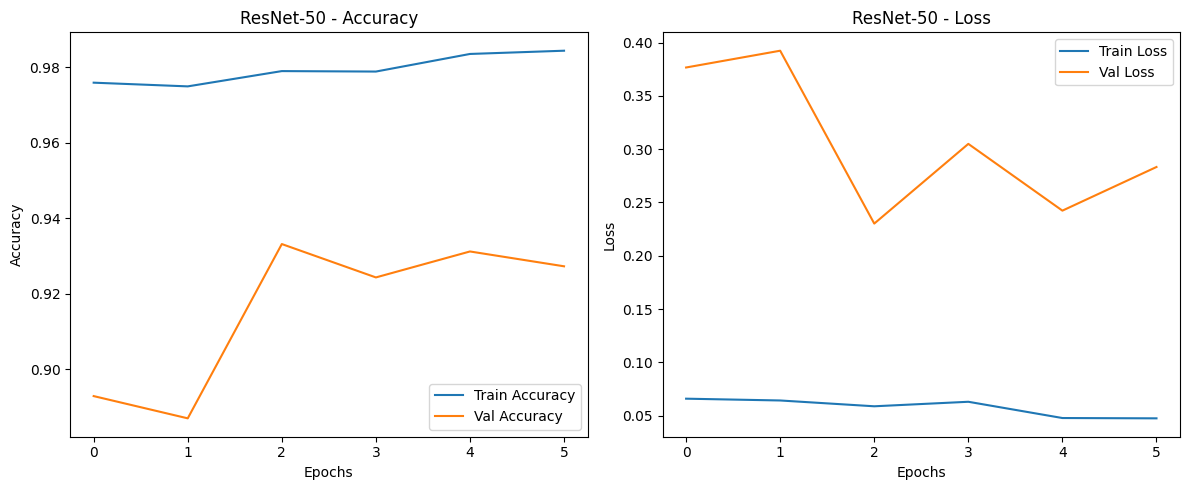

In [ ]:
import matplotlib.pyplot as plt

def plot_resnet_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('ResNet-50 - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('ResNet-50 - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_resnet_history(history)


**5- Make Predictions on Test Set**

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# Load best saved ResNet-50 model
resnet_model = load_model("best_resnet50_model.keras")

# Prepare predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = resnet_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

**6- Visualisizing the Test Predictions**

Found 1020 files belonging to 4 classes.


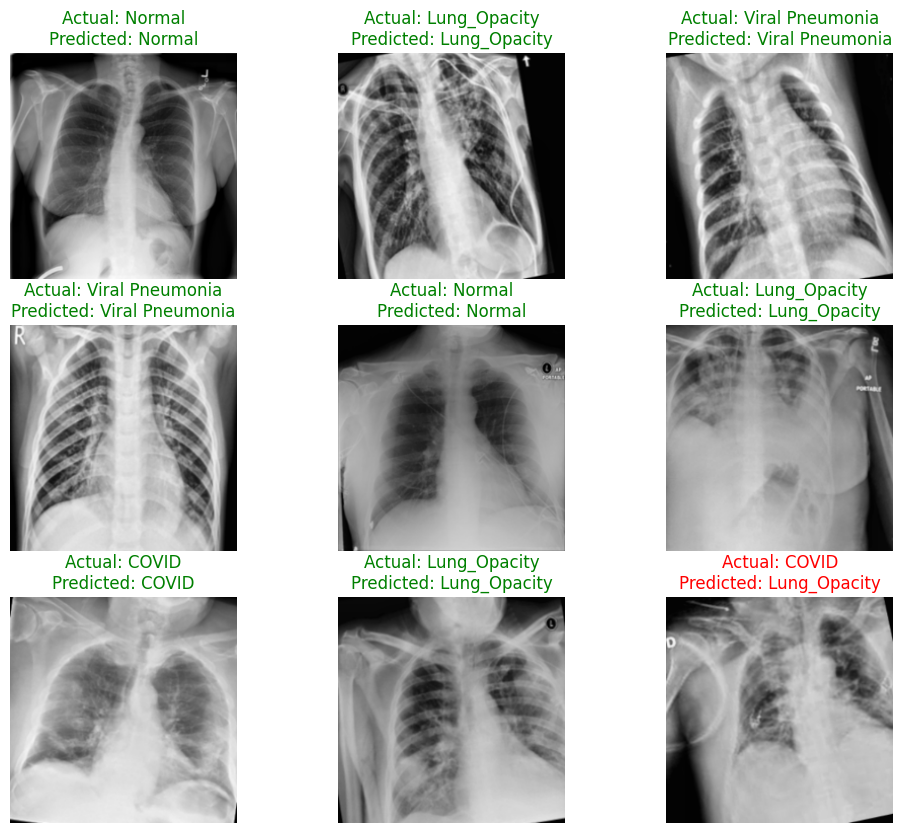

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reload test dataset temporarily to get class names
base_dir = "/content/drive/MyDrive/Colab Notebooks/Final_Dataset"

temp_test_ds = image_dataset_from_directory(
    directory=os.path.join(base_dir, "test"),
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)
class_names = temp_test_ds.class_names

# Convert test_ds to list for indexing
image_batches = list(test_ds.as_numpy_iterator())
all_images = []
for batch in image_batches:
    images, _ = batch
    all_images.extend(images)

# Sample 9 random indices
sample_indices = random.sample(range(len(all_images)), 9)

# Plot predictions
plt.figure(figsize=(12, 10))

for i, idx in enumerate(sample_indices):
    img = all_images[idx]  # <-- FIXED HERE
    img_display = (img * 255).astype("uint8")  # convert from 0–1 to 0–255
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    color = "green" if true_label == pred_label else "red"

    plt.subplot(3, 3, i + 1)
    plt.imshow(img_display, cmap="gray")
    plt.title(f"Actual: {true_label}\nPredicted: {pred_label}", color=color)
    plt.axis("off")



**7- Classification Report**

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


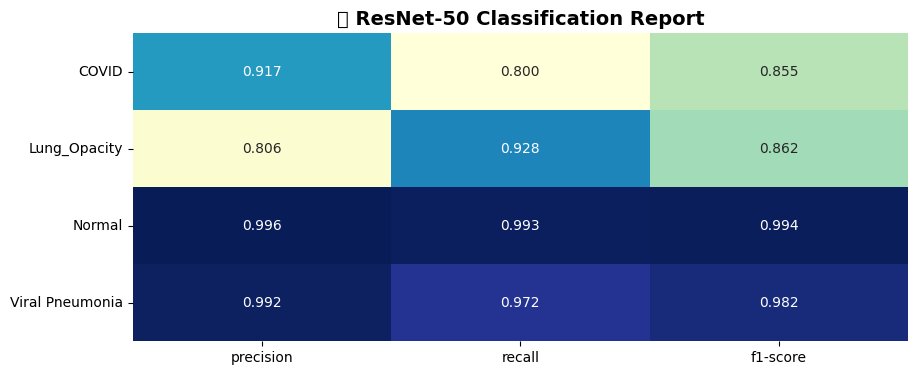

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report as dictionary
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Round values for better readability
report_df = report_df.round(3)

# Display the table
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.heatmap(report_df.iloc[:-3, :-1], annot=True, fmt=".3f", cmap="YlGnBu", cbar=False)
plt.title("📋 ResNet-50 Classification Report", fontsize=14, fontweight='bold')
plt.yticks(rotation=0)
plt.show()


**8- Confusion Matrix**

<ipython-input-53-0385b12c2f06>:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


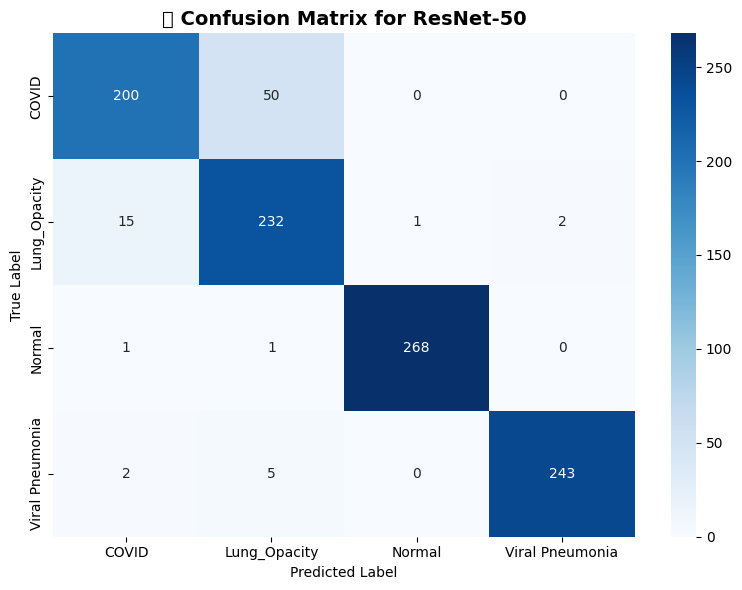

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("📊 Confusion Matrix for ResNet-50", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# Model To Predict

Saving Covid Image downloded from Google.jpg to Covid Image downloded from Google.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


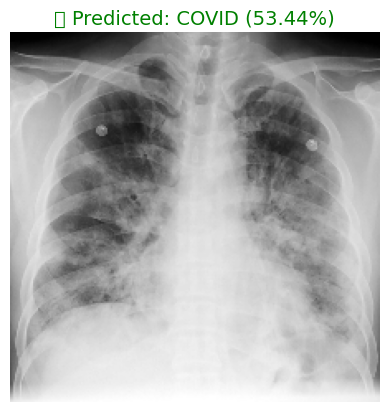

🔎 Class Probabilities:
COVID: 53.44%
Lung_Opacity: 46.39%
Normal: 0.18%
Viral Pneumonia: 0.00%


In [ ]:
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load ResNet-50 model
model = load_model("best_resnet50_model.keras")
class_names = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]

# Upload image
uploaded = files.upload()

for file_name in uploaded.keys():
    img_path = file_name
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # 🔍 Safety check for invalid/blank images
    img_mean = np.mean(img_array)
    img_std = np.std(img_array)

    plt.imshow(img)
    plt.axis('off')

    if img_mean > 0.95 or img_std < 0.05:
        plt.title("⚠️ Invalid Image: Likely Blank or Non-Xray", fontsize=14, color='red')
        plt.show()
        continue

    # 🔮 Predict
    predictions = model.predict(img_array_expanded)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    # 🖼️ Show result
    plt.title(f"✅ Predicted: {predicted_class} ({confidence:.2%})", fontsize=14, color='green')
    plt.show()

    # 📊 Show all class probabilities
    print("🔎 Class Probabilities:")
    for i, prob in enumerate(predictions[0]):
        print(f"{class_names[i]}: {prob:.2%}")


In [ ]:
!ls

 augmented_distribution_plot.png	  drive
 best_custom_cnn_model.keras		  flipping_augmentation.png
 best_improved_cnn_model.keras		  labeled_augmented_batch.png
 best_resnet50_model.keras		  noise_blur_comparison.png
 bestresnet50model.keras		  rotation_augmentation.png
 class_distribution.png			  sample_data
 confusion_matrix.png			  updated_class_distribution.png
 contrast_comparison.png		  zoomed_augmentation.png
'Covid Image downloded from Google.jpg'


# **SAVE MODEL FOR BACKEND INTEGRATION**

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/best_resnet50_model.keras")
!ls "/content/drive/MyDrive/Colab Notebooks"
files.download("/content/drive/MyDrive/Colab Notebooks/best_resnet50_model.keras")


'ADS2 - Tutorial 2 - PySpark Basics.ipynb'
 AmazonBooks.csv
 Aoun_PySpark_Assignment_Feb25.ipynb
 Augmented
 best_resnet50_model.keras
'Bhavaya-ML Assignment'
'Copy of Pneumonia-Detection (1).ipynb'
'Copy of Pneumonia-Detection.ipynb'
 COVID-19_Radiography_Dataset
'E commerce'
 Final_Dataset
 games-data.csv
 Hackathon_dataset_4.ipynb
 Hackathon.ipynb
 intel_image_classification
'Keras_Assignment_Dec2024 (1).ipynb'
'Keras_Assignment_Dec2024 (2).ipynb'
'Keras_Assignment_Dec2024 (3).ipynb'
 Keras_Assignment_Dec2024.ipynb
'Keras_Assignment_Dec2024 -Tahreem.ipynb'
'Machine Learning Tutorial.ipynb'
'ML Assignment.ipynb'
'Pneumonia_Detection (1).ipynb'
 Pneumonia-Detection.ipynb
'PySpark_Assignment_Feb25 (1).ipynb'
'PySpark_Assignment_Feb25 (2).ipynb'
 PySpark_Assignment_Feb25.ipynb
'PySpark_Assignment_Sep24_(2024_2025_A) (23005633) (1).ipynb'
'PySpark_Assignment_Sep24_(2024_2025_A) (23005633).ipynb'
'PySpark_Assignment_Sep24_(2024_2025_A) .ipynb'
'Smart City'
 spark-3.3.0-bin-hadoop3
 spark-

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/best_resnet50_model.h5")
!ls "/content/drive/MyDrive/Colab Notebooks"
files.download("/content/drive/MyDrive/Colab Notebooks/best_resnet50_model.h5")


'ADS2 - Tutorial 2 - PySpark Basics.ipynb'
 AmazonBooks.csv
 Aoun_PySpark_Assignment_Feb25.ipynb
 Augmented
 best_resnet50_model.h5
 best_resnet50_model.keras
'Bhavaya-ML Assignment'
'Copy of Pneumonia-Detection (1).ipynb'
'Copy of Pneumonia-Detection.ipynb'
 COVID-19_Radiography_Dataset
'E commerce'
 Final_Dataset
 games-data.csv
 Hackathon_dataset_4.ipynb
 Hackathon.ipynb
 intel_image_classification
'Keras_Assignment_Dec2024 (1).ipynb'
'Keras_Assignment_Dec2024 (2).ipynb'
'Keras_Assignment_Dec2024 (3).ipynb'
 Keras_Assignment_Dec2024.ipynb
'Keras_Assignment_Dec2024 -Tahreem.ipynb'
'Machine Learning Tutorial.ipynb'
'ML Assignment.ipynb'
'Pneumonia_Detection (1).ipynb'
 Pneumonia-Detection.ipynb
'PySpark_Assignment_Feb25 (1).ipynb'
'PySpark_Assignment_Feb25 (2).ipynb'
 PySpark_Assignment_Feb25.ipynb
'PySpark_Assignment_Sep24_(2024_2025_A) (23005633) (1).ipynb'
'PySpark_Assignment_Sep24_(2024_2025_A) (23005633).ipynb'
'PySpark_Assignment_Sep24_(2024_2025_A) .ipynb'
'Smart City'
 spark-3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>